In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!ls pyWake/

pywake_FUGA.nc        pywake_linear_bast.nc


In [3]:
!ls foxes/

power_validation_inputs_foxes_A.csv
power_validation_inputs_foxes_B.csv
power_validation_inputs_foxes_C.csv
power_validation_inputs_foxes_D.csv
power_validation_inputs_foxes_E.csv
power_validation_inputs_foxes_F.csv
power_validation_inputs_foxes_G.csv
turbine_data_validation_inputs_foxes_A.nc
turbine_data_validation_inputs_foxes_B.nc
turbine_data_validation_inputs_foxes_C.nc
turbine_data_validation_inputs_foxes_D.nc
turbine_data_validation_inputs_foxes_E.nc
turbine_data_validation_inputs_foxes_F.nc
turbine_data_validation_inputs_foxes_G.nc


In [4]:
!ls WAYVE/

power_windio_les_validation_wayve.csv


In [5]:
pywake_no_blockage = xr.load_dataset('pyWake/pywake_linear_bast.nc')
pywake_blockage = xr.load_dataset('pyWake/pywake_FUGA.nc')

In [6]:
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
foxes_pred = [xr.load_dataset('foxes/turbine_data_validation_inputs_foxes_%s.nc' % letters[ii]) for ii in range(len(letters))]

In [7]:
wayve_dat = pd.read_csv('WAYVE/power_windio_les_validation_wayve.csv')

In [10]:
code_saturne_dat = pd.read_csv('code_saturne/power_validation_code_saturne.csv')
code_saturne_rho = pd.read_csv('code_saturne/Density_validation_code_saturne.csv')
##uncomment to try density correction
#rho_to_use = 1.225
#code_saturne_dat.values[:,1:] = rho_to_use*code_saturne_dat.values[:,1:]/code_saturne_rho.values[:,1:]

In [13]:
np.array([wayve_dat.iloc[0].values[1:].max(), code_saturne_dat.iloc[0].values[1:].max(), 1e3 * foxes_pred[0].isel(state=0).P.values.max(),  pywake_no_blockage.isel(time=0).Power.values.max()]) / 1e6

array([9.19739901, 8.33665592, 9.56214647, 9.56215049])

In [24]:
case_num = 3
les_dat = pd.read_csv('LES/power_windio_les_validation.csv')


ok


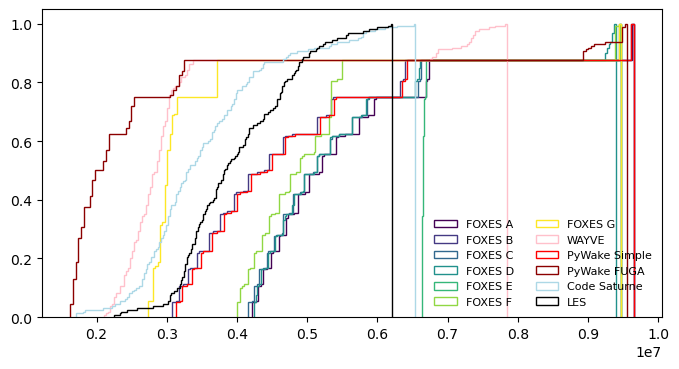

In [26]:
plt.subplots(figsize=(8, 4))

foxes_colors = plt.cm.viridis(np.linspace(0, 1, len(letters)))
pywake_colors = ['red', 'darkred']

for ll in range(len(letters)):
    plt.hist(foxes_pred[ll].isel(state=case_num).P * 1e3, 200, density=True, cumulative=True, histtype='step', edgecolor=foxes_colors[ll], label='FOXES %s' % letters[ll])
plt.hist(wayve_dat.iloc[case_num].values[1:], 200, cumulative=True, density=True, histtype='step', edgecolor='pink', label='WAYVE')
plt.hist(pywake_no_blockage.isel(time=case_num).Power, 200, density=True, cumulative=True, histtype='step', edgecolor=pywake_colors[0], label='PyWake Simple')
plt.hist(pywake_blockage.isel(time=case_num).Power, 200, density=True, cumulative=True, histtype='step', edgecolor=pywake_colors[1], label='PyWake FUGA')
plt.hist(code_saturne_dat.iloc[case_num].values[1:], 200, density=True, cumulative=True, histtype='step', edgecolor='lightblue', label='Code Saturne')
plt.hist(les_dat.iloc[case_num].values[1:], 200, cumulative=True, density=True, histtype='step', edgecolor='k', label='LES')
plt.legend(ncol=2, prop={'size': 8}, loc='lower right')
print('ok')

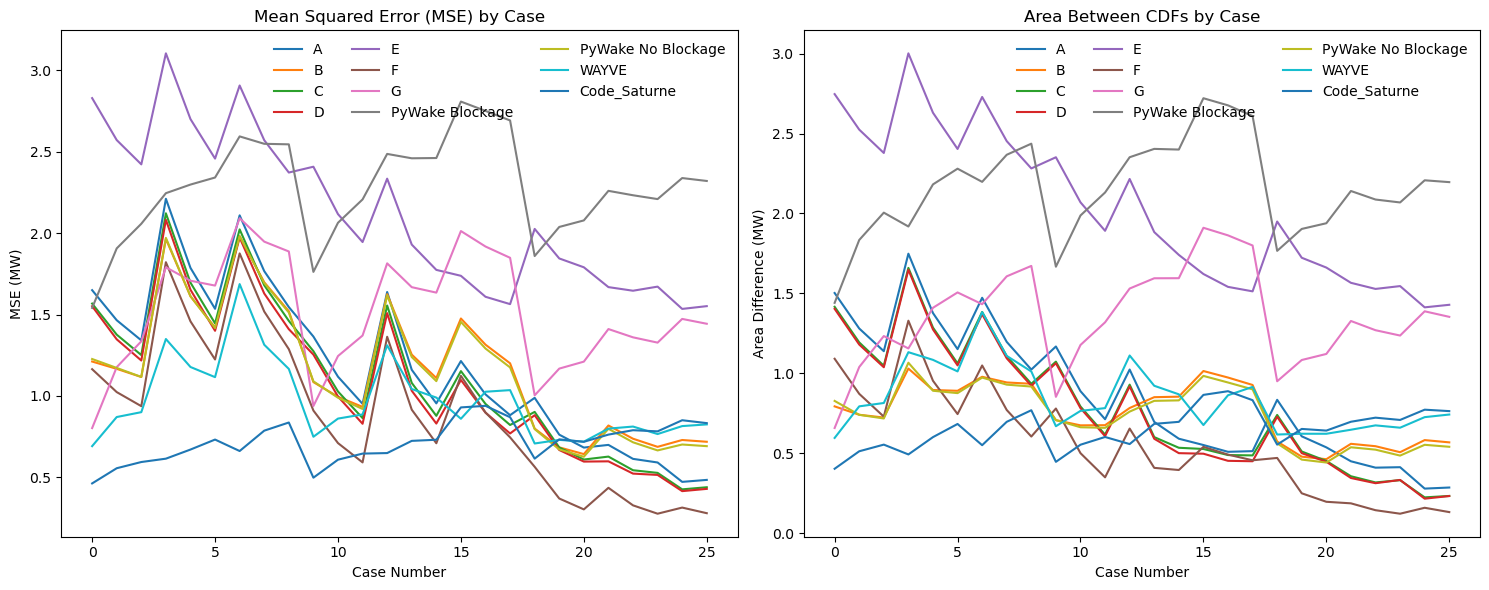

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Number of cases
num_cases = 26

# Initialize lists for storing metrics
mse_values = {letter: [] for letter in letters}
mse_values['PyWake Blockage'] = []
mse_values['PyWake No Blockage'] = []
mse_values['WAYVE'] = []
mse_values['Code_Saturne'] = []

area_diff_values = {letter: [] for letter in letters}
area_diff_values['PyWake Blockage'] = []
area_diff_values['PyWake No Blockage'] = []
area_diff_values['WAYVE'] = []
area_diff_values['Code_Saturne'] = []

# Common grid for CDF
common_grid = np.linspace(0, 1.3e7, 1000)  # Example range, adjust as needed

# Function to calculate area between CDFs
def area_between_cdfs(data1, data2, grid):
    cdf1 = np.interp(grid, np.sort(data1), np.linspace(0, 1, len(data1)))
    cdf2 = np.interp(grid, np.sort(data2), np.linspace(0, 1, len(data2)))
    return np.trapz(np.abs(cdf1 - cdf2), grid) / 1e6

# Calculating MSE and area between CDFs for each case
for case_num in range(num_cases):
    les_case_values = les_dat.iloc[case_num].values[1:]

    # FOXES models
    for ll, letter in enumerate(letters):
        foxes_values = foxes_pred[ll].isel(state=case_num).P.values * 1e3
        mse = np.sqrt(np.mean((foxes_values - les_case_values) ** 2)) / 1e6
        mse_values[letter].append(mse)
        area_diff = area_between_cdfs(foxes_values, les_case_values, common_grid)
        area_diff_values[letter].append(area_diff)

    # PyWake Blockage
    pywake_blockage_values = pywake_blockage.isel(time=case_num).Power.values
    mse = np.sqrt(np.mean((pywake_blockage_values - les_case_values) ** 2)) / 1e6
    mse_values['PyWake Blockage'].append(mse)
    area_diff = area_between_cdfs(pywake_blockage_values, les_case_values, common_grid)
    area_diff_values['PyWake Blockage'].append(area_diff)

    # PyWake No Blockage
    pywake_no_blockage_values = pywake_no_blockage.isel(time=case_num).Power.values
    mse = np.sqrt(np.mean((pywake_no_blockage_values - les_case_values) ** 2)) / 1e6
    mse_values['PyWake No Blockage'].append(mse)
    area_diff = area_between_cdfs(pywake_no_blockage_values, les_case_values, common_grid)
    area_diff_values['PyWake No Blockage'].append(area_diff)

    # Code_Saturne
    saturne_values = code_saturne_dat.iloc[case_num].values[1:]
    mse = np.sqrt(np.mean((saturne_values - les_case_values) ** 2)) / 1e6
    mse_values['Code_Saturne'].append(mse)
    area_diff = area_between_cdfs(saturne_values, les_case_values, common_grid)
    area_diff_values['Code_Saturne'].append(area_diff)
    
    # WAYVE
    wayve_values = wayve_dat.iloc[case_num].values[1:]
    mse = np.sqrt(np.mean((wayve_values - les_case_values) ** 2)) / 1e6
    mse_values['WAYVE'].append(mse)
    area_diff = area_between_cdfs(wayve_values, les_case_values, common_grid)
    area_diff_values['WAYVE'].append(area_diff)

# Plotting the results
plt.figure(figsize=(15, 6))

# MSE plot
plt.subplot(1, 2, 1)
for key, value in mse_values.items():
    plt.plot(range(num_cases), value, label=key)
plt.title('Mean Squared Error (MSE) by Case')
plt.xlabel('Case Number')
plt.ylabel('MSE (MW)')
plt.legend(ncol=3)

# Area between CDFs plot
plt.subplot(1,2, 2)
for key, value in area_diff_values.items():
    plt.plot(range(num_cases), value, label=key)
plt.title('Area Between CDFs by Case')
plt.xlabel('Case Number')
plt.ylabel('Area Difference (MW)')
plt.legend(ncol=3)

plt.tight_layout()
plt.show()
